In [1]:
import glob
import os
import h5py

import cv2
import numpy as np

def normalize_depth(disparity_map):
    disparityf = disparity_map.astype(np.float32)
    disparity_not_zero = disparityf > 0.0
    disparity_zero = disparityf == 0.0
    true_depth = np.zeros(disparityf.shape)
    A = 1.0
    B = 0.0005
    max_depth = 1.0
    true_depth[disparity_not_zero] = 1/(A+B*disparityf[disparity_not_zero])
    true_depth[disparity_zero] = max_depth

    min_depth,max_depth = true_depth.min(), true_depth.max()
    true_depth_normalized = (true_depth - min_depth) / (max_depth - min_depth)
    return true_depth_normalized


def load_depth_from_hdf5(hdf5_path, depth_path, return_orig=False):
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        # Access the dataset
        dataset = hdf5_file[depth_path]
        depth_map_u16 = dataset[:]
        
        # Retrieve mean and std attributes
        depth_map_min = dataset.attrs['min']
        depth_map_range = dataset.attrs['range']
        
        # Convert uint16 back to normalized float
        divisor = 65535.0 if depth_map_u16.dtype == np.uint16 else 255.0 
        depth_map_normalized = depth_map_u16.astype(np.float32) / divisor
        
        # Denormalize to reconstruct the original depth map
        depth = depth_map_normalized * depth_map_range + depth_map_min
        
        #out_depth = depth / np.max(depth)
        out_depth = normalize_depth(depth)

        if return_orig:
            return out_depth, depth
        else:
            return out_depth

In [2]:
class TestDepthInpaintingTrainWithHdf5Dataset:
    def __init__(self,indir, hdf5_path, mask_generator, transform):
        self.in_files = list(glob.glob(os.path.join(indir, '**', '*.jpg'), recursive=True))
        self.hdf5_path = hdf5_path
        
        # TODO note:
        # read self.in_files and create equivalent depth path inside the hdf5 file that we'll look up in load_depth_from_hdf5

        self.depth_files = [path.split(indir,1)[1].replace("\\","/").removesuffix(".jpg") for path in self.in_files]
        self.mask_generator = mask_generator
        self.transform = transform
        self.iter_i = 0

indir_train="D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/train"
hdf5_path_train="D:/dev/lama_stereoinpainting/docker/places/depth/train_large_places365standard_disparity_u8.hdf5"
thisTest_train = TestDepthInpaintingTrainWithHdf5Dataset(indir_train, hdf5_path_train, None, None)

1803460
D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/train\data_large\f\farm\00001629.jpg


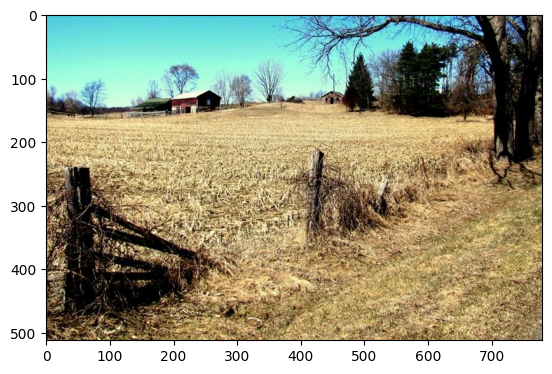

loading depth /data_large/f/farm/00001629


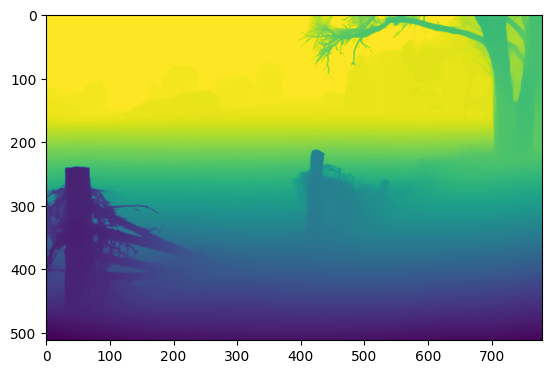

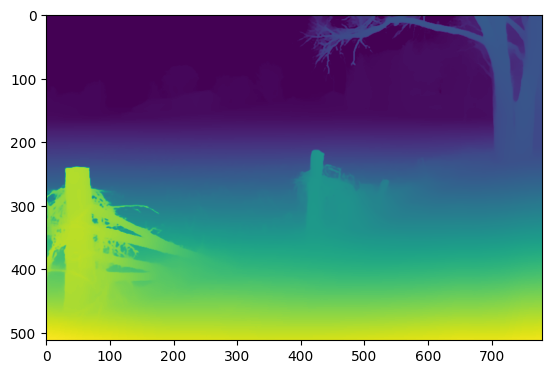

0.0 1.0
0.0 463.9471


In [3]:
import matplotlib.pyplot as plt

def test_rand_image(dataset):
    selected = np.random.randint(0, len(dataset.in_files))

    print(len(dataset.in_files))
    print(dataset.in_files[selected])

    tst_img = cv2.cvtColor(cv2.imread(dataset.in_files[selected]),cv2.COLOR_BGR2RGB)
    plt.imshow(tst_img)
    plt.show()

    depth_path = dataset.depth_files[selected]
    print(f"loading depth {depth_path}")

    depth_img, orig_depth = load_depth_from_hdf5(dataset.hdf5_path, depth_path, True)
    plt.imshow(depth_img)
    plt.show()
    plt.imshow(orig_depth)
    plt.show()
    print(depth_img.min(), depth_img.max())
    print(orig_depth.min(), orig_depth.max())

test_rand_image(thisTest_train)


1989
D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/val\Places365_test_00223666_crop000.png


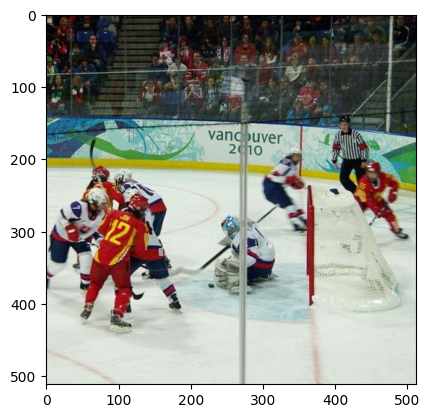

loading depth val/Places365_test_00223666_crop000


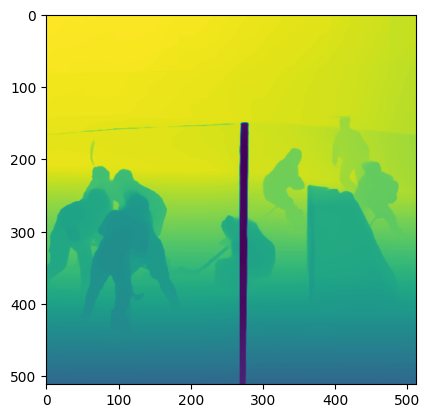

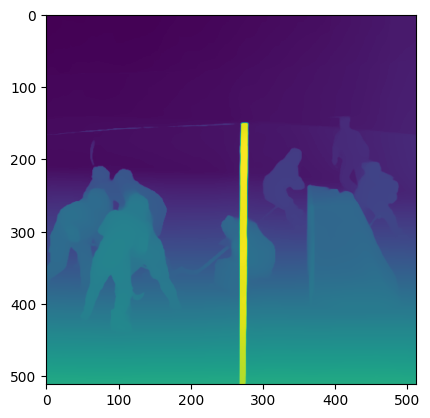

0.0 1.0
0.50851727 529.90393


In [4]:
class TestDepthInpaintingEvaluationWithHdf5Dataset:
    def __init__(self, img_datadir, hdf5_path, img_suffix='.jpg', pad_out_to_modulo=None, scale_factor=None):
        self.img_datadir = img_datadir
        self.hdf5_path = hdf5_path
        self.mask_filenames = sorted(list(glob.glob(os.path.join(self.img_datadir, '**', '*mask*.*'), recursive=True)))
        self.img_filenames = [fname.rsplit('_mask', 1)[0] + img_suffix for fname in self.mask_filenames]
        depth_root = "val" if "/val" in img_datadir else "visual_test"
        self.depth_paths = [path.replace(img_datadir, depth_root).replace("\\","/").removesuffix(img_suffix) for path in self.img_filenames]
        self.pad_out_to_modulo = pad_out_to_modulo
        self.scale_factor = scale_factor

indir_val = "D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/val"
hdf5_path_val="D:/dev/lama_stereoinpainting/docker/places/depth/val_large_places365standard_disparity_u8.hdf5"
thisTest_val = TestDepthInpaintingEvaluationWithHdf5Dataset(indir_val, hdf5_path_val, ".png", None, None)

thisTest_val.in_files = thisTest_val.img_filenames
thisTest_val.depth_files = thisTest_val.depth_paths

test_rand_image(thisTest_val)

100
D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/visual_test\Places365_val_00025530_crop000.png


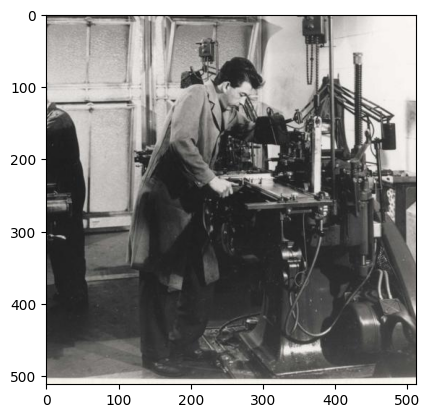

loading depth visual_test/Places365_val_00025530_crop000


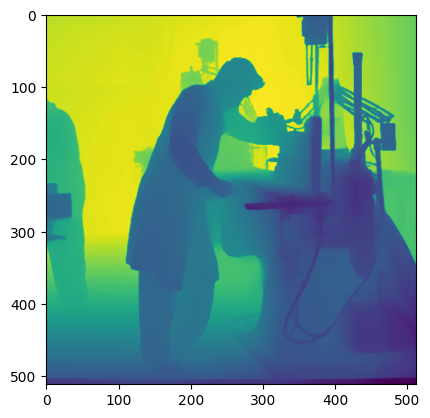

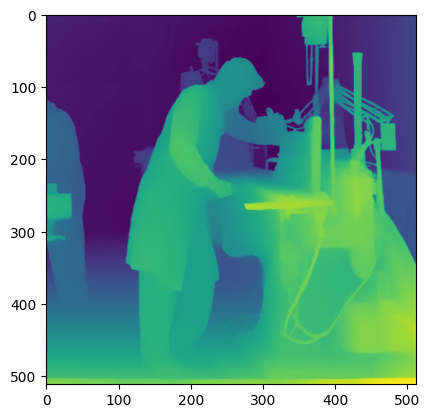

0.0 1.0
0.0 346.23776


In [5]:
indir_visual_test = "D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/visual_test"
hdf5_path_visual_test="D:/dev/lama_stereoinpainting/docker/places/depth/val_large_places365standard_disparity_u8.hdf5"
thisTest_visual_test = TestDepthInpaintingEvaluationWithHdf5Dataset(indir_visual_test, hdf5_path_visual_test, ".png", None, None)

thisTest_visual_test.in_files = thisTest_visual_test.img_filenames
thisTest_visual_test.depth_files = thisTest_visual_test.depth_paths

test_rand_image(thisTest_visual_test)

In [7]:
from tqdm.notebook import tqdm

def check_depth_existance(dataset):
    broken_depth = []
    for i in tqdm(range(len(dataset.in_files))):
        depth_path = dataset.depth_files[i]
        with h5py.File(dataset.hdf5_path, 'r') as hdf5_file:
            if depth_path not in hdf5_file:
                print(f"Depth path {depth_path} not found in hdf5 file")
                broken_depth.append(depth_path)
            if not ('min' in hdf5_file[depth_path].attrs and 'range' in hdf5_file[depth_path].attrs):
                print(f"Depth path {depth_path} missing min/range attributes")
                broken_depth.append(depth_path)

    return broken_depth

check_depth_existance(thisTest_train)
check_depth_existance(thisTest_val)
check_depth_existance(thisTest_visual_test)

  0%|          | 0/1803460 [00:00<?, ?it/s]

  0%|          | 0/1989 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[]

In [3]:
import h5py
import time

# Test on a sample file
def get_all_datasets(hdf5_file):
    datasets = []
    def collect_datasets(name, obj):
        if isinstance(obj, h5py.Dataset):
            datasets.append(name)
    with h5py.File(hdf5_file, 'r') as hdf:
        hdf.visititems(collect_datasets)
    return datasets

hdf5_file_path = 'C:/experiments/places_dataset/train_large_places365standard_jpgs.hdf5'

start_time = time.time()
datasets = get_all_datasets(hdf5_file_path)
end_time = time.time()

print(f"Found {len(datasets)} datasets in {end_time - start_time:.4f} seconds.")


Found 1803460 datasets in 190.2449 seconds.


In [7]:
class TestJPGInHdf5_DepthInpaintingTrainWithHdf5Dataset:
    def __init__(self,indir, hdf5_path, mask_generator, transform):
        self.hdf5_path = hdf5_path

        if ("hdf5" in indir):
            print("Parsing hdf5 file")
            self.in_files = get_all_datasets(indir)
            print(f"Found {len(datasets)}.")
            self.depth_files = [path.replace("\\","/").removesuffix(".jpg") for path in self.in_files]
        else:
            self.in_files = list(glob.glob(os.path.join(indir, '**', '*.jpg'), recursive=True))
            self.depth_files = [path.split(indir,1)[1].replace("\\","/").removesuffix(".jpg") for path in self.in_files]
        
        # TODO note:
        # read self.in_files and create equivalent depth path inside the hdf5 file that we'll look up in load_depth_from_hdf5

        
        self.mask_generator = mask_generator
        self.transform = transform
        self.iter_i = 0

In [8]:
indir_train="C:/experiments/places_dataset/train_large_places365standard_jpgs.hdf5"
hdf5_path_train="C:/experiments/places_dataset/train_large_places365standard_disparity_u8.hdf5"
thisTest_train = TestJPGInHdf5_DepthInpaintingTrainWithHdf5Dataset(indir_train, hdf5_path_train, None, None)

Parsing hdf5 file
Found 1803460.
